#One to Many - Multi Layer - LSTM Model (Text Generation)

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

import time

In [ ]:
#Signal Class to handle keybord interrupts
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [ ]:
# Create Parameter class to store weights, biases and their gradients (Similar to Tensor)
class Parameter:
  def __init__(self, name, value):
    self.name = name
    self.value = value #parameter value
    self.grad = np.zeros_like(value) #derivative
    self.m_grad = np.zeros_like(value) #momentum for AdaGrad (memory variables for Adagrad)

  def __repr__(self):
    return "Parameter [name = " + self.name + ", value.shape = "+ str(self.value.shape) +"]"

  def zero_grad(self):
    self.grad = np.zeros_like(self.value)

In [ ]:
class LSTM_Parameters:
  def __init__ (self, hidden_size, input_size, output_size):
    self.W_f = Parameter('W_f', np.random.randn(hidden_size, input_size+hidden_size)*0.01)#INPUT to hidden layer of forgot gate [input_size+hidden_size, hidden_size]
    self.W_i = Parameter('W_i', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of input gate [vocal_size+hidden_size, hidden_size]
    self.W_g = Parameter('W_g', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of  gate [vocal_size+hidden_size, hidden_size]
    self.W_o = Parameter('W_o', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of output gate [vocal_size+hidden_size, hidden_size]
    self.W_hy = Parameter('W_hy', np.random.randn(output_size, hidden_size)*0.01) #hidden to output [hidden_size, input_size]

    self.b_f = Parameter('b_f',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_i = Parameter('b_i',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_g = Parameter('b_g',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_o = Parameter('b_o',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_hy = Parameter('b_hy',np.zeros((output_size,1))) #output layer bias [hidden_size,1]
  
  def zero_grad(self):
    for p in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      p.zero_grad()
  
  def clip_grad(self):
    for g in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      np.clip(g.grad, -1, 1, out=g.grad) # clip to mitigate exploding gradients
  
  def adagrad_optimizer(self, learning_rate = 1e-1):
    for p in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      p.m_grad += p.grad * p.grad
      p.value += -learning_rate * p.grad / np.sqrt(p.m_grad + 1e-8) # adagrad update
      

In [ ]:
# LSTM Class to store all the weights and biases
class LSTM:
  def __init__(self, hidden_size, input_size, sequence_length, learning_rate = 1e-1, weight_sd = 0.1, lstm_layers = 1):
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.sequence_length = sequence_length
    self.learning_rate = learning_rate
    self.weight_sd = weight_sd
    self.lstm_layers = lstm_layers
    self.lstm_parameters = []
    self.lstm_parameters.append(LSTM_Parameters(hidden_size, input_size, input_size))

    for i in range(1,lstm_layers):
      print(i)
      self.lstm_parameters.append(LSTM_Parameters(hidden_size, hidden_size, input_size))

    self.plot_iter = np.zeros((0))
    self.plot_loss = np.zeros((0))
    self.smt_loss = np.zeros((0))


  def __repr__(self):
    return "LSTM: [input_size = "+str(self.input_size) +", hidden_size = "+ str(self.hidden_size)+", sequence_length = "+str(self.sequence_length)+", lstm_layers = "+str(self.lstm_layers)+", learning_rate = "+str(self.learning_rate)+"]"
  
  def zero_grads(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].zero_grad()
  
  def clip_grads(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].clip_grad()

  def adagrad_optimizer(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].adagrad_optimizer()

  # Sigmoid Function:
  def sigmoid(self,x):
    return 1 / (1 + np.exp(-x))
  
  def text_generation_LSTM_cell_forward(self, input, h_prev, c_prev, layer):
    # Stack h and x together
    inp = np.vstack((h_prev, input)) # h before x

    # Forward Pass through four gates of LSTM
    f = self.sigmoid(np.dot(self.lstm_parameters[layer].W_f.value, inp) + self.lstm_parameters[layer].b_f.value)
    i = self.sigmoid(np.dot(self.lstm_parameters[layer].W_i.value, inp) + self.lstm_parameters[layer].b_i.value)
    g = np.tanh(np.dot(self.lstm_parameters[layer].W_g.value, inp) + self.lstm_parameters[layer].b_g.value)
    o = self.sigmoid(np.dot(self.lstm_parameters[layer].W_o.value, inp)+self.lstm_parameters[layer].b_o.value)

    # Calulate cell state: (Element Wise multiplication and addition)
    c_t = np.multiply(c_prev, f) + np.multiply(i, g)
    c_tanh = np.tanh(c_t)
    h_t = np.multiply(c_tanh,o)   #ht generated for current timestemp (hidden_size X 1)

    return h_t, c_t, f, i, g, o

  def text_generation_LSTM_cell_calculate_y(self, h_t, layer):
    # Calculate y 
    y = np.dot(self.lstm_parameters[layer].W_hy.value, h_t) + self.lstm_parameters[layer].b_hy.value #y before passing through softmax function (input_size X 1)
    
    # softmax function:
    p = np.exp(y) / np.sum(np.exp(y)) # (input_size X 1)
    return y, p

  def text_generation_modified_forward(self, input, h_prev, c_prev):
    h_t, c_t, f_t, i_t, g_t, o_t = np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object),np.empty(self.lstm_layers, dtype=object)
    
    for i in range(self.lstm_layers):
      h_t[i], c_t[i], f_t[i], i_t[i], g_t[i], o_t[i] = self.text_generation_LSTM_cell_forward(input, h_prev[i], c_prev[i], i)
      input = h_t[i]
    
    y, p = self.text_generation_LSTM_cell_calculate_y(h_t[self.lstm_layers-1], self.lstm_layers-1)

    return h_t, c_t, f_t, i_t, g_t, o_t, y, p


  def forward(self, input, h_prev, c_prev):
    # Stack h and x together
    inp = np.vstack((h_prev, input)) # h before x

    # Forward Pass through four gates of LSTM
    f = self.sigmoid(np.dot(self.lstm_parameters.W_f.value, inp) + self.lstm_parameters.b_f.value)
    i = self.sigmoid(np.dot(self.lstm_parameters.W_i.value, inp) + self.lstm_parameters.b_i.value)
    g = np.tanh(np.dot(self.lstm_parameters.W_g.value, inp) + self.lstm_parameters.b_g.value)
    o = self.sigmoid(np.dot(self.lstm_parameters.W_o.value, inp)+self.lstm_parameters.b_o.value)

    # Calulate cell state: (Element Wise multiplication and addition)
    c_t = np.multiply(c_prev, f) + np.multiply(i, g)
    c_tanh = np.tanh(c_t)
    h_t = np.multiply(c_tanh,o)   #ht generated for current timestemp (hidden_size X 1)
    # Calculate y 
    y = np.dot(self.lstm_parameters.W_hy.value, h_t) + self.lstm_parameters.b_hy.value #y before passing through softmax function (input_size X 1)
    # softmax function:
    p = np.exp(y) / np.sum(np.exp(y)) # (input_size X 1)
    return h_t, c_t, y, p, f, i, g, o

  # Multiple Layer
  def text_generation_modified_sample_LSTM(self, h_prev, c_prev, seed_ix, sequence_length):
    # Prepare initial input for LSTM
    x = np.zeros((self.input_size,1))
    x[seed_ix] = 1

    h_t = h_prev
    c_t = c_prev

    ixes = []
    for t in range(sequence_length):
      h_t, c_t, _, _, _, _, _, p = self.text_generation_modified_forward(x, h_t, c_t)

      #get index of maximum probability
      ix = np.random.choice(range(self.input_size), p=p.ravel())
      
      x = np.zeros((self.input_size, 1))
      x[ix] = 1
      ixes.append(ix)

    return ixes

  # Single Layer
  def sample_LSTM(self, h_prev, c_prev, seed_ix, sequence_length):
    # Prepare initial input for LSTM
    x = np.zeros((self.input_size,1))
    x[seed_ix] = 1

    h_t = h_prev
    c_t = c_prev

    ixes = []
    for t in range(sequence_length):
      h_t, c_t, _, p, _, _, _, _ = self.forward(x, h_t, c_t)

      #get index of maximum probability
      ix = np.random.choice(range(self.input_size), p=p.ravel())
      
      x = np.zeros((self.input_size, 1))
      x[ix] = 1
      ixes.append(ix)

    return ixes

  def LSTM_cell_backpropogation(self,cs_prev, hs_prev, xs, o_s, f_s, g_s, i_s, cs, dh_next, dc_next, layer):
    # dht ==> dh_next
    # o_s[t] ==> o_s at timestemp t
    # f_s[t] ==> f_s
    # g_s[t] ==> g_s
    # i_s[t] ==> i_s
    # xs[t] ==> xs
    # cs[t] ==> cs ==> cell state output at t
    # cs[t-1] ==> cs_prev
    # hs[t-1] ==> hs_prev
    # dcnext ==> dc_next
    dc_tanh = dh_next * o_s # dL/dc_tanh
    dct = dc_tanh*(1-(np.tanh(cs)**2)) + dc_next # dL/dct -->dct

    dcnext = dct*f_s #dL/dc_(t-1)

    inp = np.vstack((hs_prev, xs)) # h before x

    #Output Gate
    d_ot = dh_next*np.tanh(cs)
    dW_o_row = d_ot * (o_s*(1-o_s))
    self.lstm_parameters[layer].W_o.grad += np.dot(dW_o_row, inp.T)
    self.lstm_parameters[layer].b_o.grad += dW_o_row

    #Forget Gate
    d_ft = dct*cs_prev
    dW_f_row = d_ft * (f_s*(1-f_s))
    self.lstm_parameters[layer].W_f.grad += np.dot(dW_f_row,inp.T)
    self.lstm_parameters[layer].b_f.grad += dW_f_row

    #Input Gate
    d_it = dct*g_s
    dW_i_row = d_it * (i_s*(1-i_s))
    self.lstm_parameters[layer].W_i.grad += np.dot(dW_i_row,inp.T)
    self.lstm_parameters[layer].b_i.grad += dW_i_row

    #Activation Gate
    d_gt = dct*i_s
    dW_g_row = d_gt * (1-(g_s**2))
    self.lstm_parameters[layer].W_g.grad += np.dot(dW_g_row,inp.T)
    self.lstm_parameters[layer].b_g.grad += dW_g_row
    
    dhnext = np.dot(self.lstm_parameters[layer].W_o.value[:, 0:hidden_size].T, dW_o_row) + np.dot(self.lstm_parameters[layer].W_f.value[:, 0:hidden_size].T, dW_f_row) + np.dot(self.lstm_parameters[layer].W_i.value[:, 0:hidden_size].T, dW_i_row) + np.dot(self.lstm_parameters[layer].W_g.value[:, 0:hidden_size].T, dW_g_row)

    dxnext = np.dot(self.lstm_parameters[layer].W_o.value[:, hidden_size:].T, dW_o_row) + np.dot(self.lstm_parameters[layer].W_f.value[:, hidden_size:].T, dW_f_row) + np.dot(self.lstm_parameters[layer].W_i.value[:, hidden_size:].T, dW_i_row) + np.dot(self.lstm_parameters[layer].W_g.value[:, hidden_size:].T, dW_g_row)

    return dhnext, dcnext, dxnext

  def text_generation_modified_lossFun_LSTM(self, inputs, targets, hprev, cprev):
    # inputs, target ==> len(input) == len(target) == sequence_length
    # hprev, cprev ==> array of arrays 

    # Dictonary to store inputs, outputs, and probabilities on each state
    xs, ys, ps = {}, {}, {}

    #Dictonary of Array of Arrays to store hidden states, cell states, f, i,g,and o for each layer and state
    hs, cs, f_s, i_s, g_s, o_s = {}, {}, {}, {}, {}, {}

    #store the hidden state and cell state at time stemp t-1
    hs[-1] = np.copy(hprev)
    cs[-1] = np.copy(cprev)

    # Initialize loss
    loss = 0

    # forward pass
    for t in range(len(targets)):

      xs[t] = np.zeros((self.input_size,1)) # encode in 1-of-k representation
      xs[t][inputs[t]] = 1

      # Forward pass:
      hs[t], cs[t], f_s[t], i_s[t], g_s[t], o_s[t], ys[t], ps[t] = self.text_generation_modified_forward(xs[t], hs[t-1], cs[t-1])

      #Cross Entropy Loss
      loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

    self.zero_grads()

    dhnext = np.empty(self.lstm_layers, dtype=object)
    dcnext = np.empty(self.lstm_layers, dtype=object)
    for i in range(self.lstm_layers):
      dhnext[i] = np.zeros((self.hidden_size,1)) # reset LSTM memory
      dcnext[i] = np.zeros((self.hidden_size,1)) # reset LSTM cell memory


    #Backward loop: t = len(targets) to 0
    for t in reversed(range(len(targets))):      
      #Calculate Loss between actual and predicted
      dy = np.copy(ps[t])
      dy[targets[t]] -= 1
      
      # ht to y
      self.lstm_parameters[self.lstm_layers-1].W_hy.grad += np.dot(dy, hs[t][self.lstm_layers-1].T) #dWhy += np.dot(Output_Delta, Hidden_Layer.T)
      self.lstm_parameters[self.lstm_layers-1].b_hy.grad += dy # bias += sum(Output_Delta)

      dhnext[self.lstm_layers-1] += np.dot(self.lstm_parameters[self.lstm_layers-1].W_hy.value.T, dy) # backprop into h ===> dL/dht --> dht

      for layer in reversed(range(1, self.lstm_layers)):
        dhnext[layer], dcnext[layer], dxnext = self.LSTM_cell_backpropogation(cs[t-1][layer], 
                                                                      hs[t-1][layer],
                                                                      hs[t][layer-1], 
                                                                      o_s[t][layer],
                                                                      f_s[t][layer], 
                                                                      g_s[t][layer], 
                                                                      i_s[t][layer],
                                                                      cs[t][layer], 
                                                                      dhnext[layer], 
                                                                      dcnext[layer], 
                                                                      layer)
        dhnext[layer-1] += dxnext
      
      dhnext[0], dcnext[0],_ = self.LSTM_cell_backpropogation(cs[t-1][0], 
                                                                      hs[t-1][0],
                                                                      xs[t], 
                                                                      o_s[t][0],
                                                                      f_s[t][0], 
                                                                      g_s[t][0], 
                                                                      i_s[t][0],
                                                                      cs[t][0], 
                                                                      dhnext[0], 
                                                                      dcnext[0], 
                                                                      0)
    self.clip_grads()

    return loss, hs[len(targets)-1], cs[len(targets)-1]
    




  # Function to display updated output to console
  def text_generation_update_status(self, batch, len_x, smooth_loss, epoch):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Iteration  VS Loss')
    ax1.plot(self.plot_iter, self.plot_loss)
    ax2.plot(self.plot_iter, self.smt_loss) #Iteration VS Smooth Loss

    display.clear_output(wait=True)
    plt.show()

    print('Train Epoch: {} [{:.0f}/{:.0f} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch, len_x, 100. * batch / len_x, smooth_loss))


  def train_text_generation(self, data, smooth_loss, epoch, char_to_idx, idx_to_char):
    ptr = 0 #Pointer to track current location in data 
    iteration = 0
    while True:
      with DelayedKeyboardInterrupt():
        # Initialize hidden and cell state for input
        hprev = np.empty(self.lstm_layers, dtype=object)
        cprev = np.empty(self.lstm_layers, dtype=object)
        for i in range(self.lstm_layers):
          hprev[i] = np.zeros((self.hidden_size,1))
          cprev[i] = np.zeros((self.hidden_size,1))

        if ptr+self.sequence_length+1 >= len(data):
          return smooth_loss
          
        inputs = [char_to_idx[ch] for ch in data[ptr:ptr+self.sequence_length]]
        targets = [char_to_idx[ch] for ch in data[ptr+1:ptr+self.sequence_length+1]]

        loss, hprev, cprev = self.text_generation_modified_lossFun_LSTM(inputs, targets, hprev, cprev)

        # Update overall loss function
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        

        if iteration % 200 == 0:
          self.plot_iter = np.append(self.plot_iter, [iteration+epoch*np.floor(len(data)/self.sequence_length)])
          self.plot_loss = np.append(self.plot_loss, [loss])
          self.smt_loss = np.append(self.smt_loss, [smooth_loss])

          self.text_generation_update_status(iteration, np.floor(len(data)/self.sequence_length), smooth_loss, epoch)

          self.test_text_generation(inputs[0], 200, idx_to_char)

        # perform parameter update with Adagrad
        self.adagrad_optimizer()
        
        ptr += self.sequence_length # move data pointer
        iteration += 1

    return smooth_loss

  def test_text_generation(self, seed_idx, output_len, idx_to_char):
    # Initialize hidden and cell state for input
    hprev = np.empty(self.lstm_layers, dtype=object)
    cprev = np.empty(self.lstm_layers, dtype=object)
    for i in range(self.lstm_layers):
      hprev[i] = np.zeros((self.hidden_size,1))
      cprev[i] = np.zeros((self.hidden_size,1))

    sample_ix = self.text_generation_modified_sample_LSTM(hprev, cprev, seed_idx, output_len)
    txt = ''.join(idx_to_char[ix] for ix in sample_ix)
    print("txt: ", txt) #'----\n %s \n----' % (txt, )
    return txt

In [ ]:
def text_generation_data_preprocessing(data):
  chars = list(set(data)) # all unique characters in the text file
  data_size, vocab_size = len(data), len(chars) #size of all the content in text file and total number of unique characters

  char_to_idx = {ch:i for i, ch in enumerate(chars)} #Chracter directory with index number
  idx_to_char = {i:ch for i, ch in enumerate(chars)} #index to unique character mapping
  
  return char_to_idx, idx_to_char, data_size, vocab_size

In [ ]:
#hyper-parameters
hidden_size = 100 #size of hidden layer of neurons
seq_length = 25 #number of steps to unroll the RNN for
learning_rate = 1e-1
weight_sd = 0.1 #weight_sd = 0.1 # Standard deviation of weights for initialization
layer = 2

In [ ]:
data = open('input.txt', 'r').read()
# data = "Hello my name is nilay patel. what is your name? where are from? good to meet you"

char_to_idx, idx_to_char, data_size, vocab_size = text_generation_data_preprocessing(data)

print('data size: ', data_size, "\nvocab size: ", vocab_size)
print("char to index: ", char_to_idx, "\nindex to char: ", idx_to_char)

data size:  99993 
vocab size:  62
char to index:  {'-': 0, 'q': 1, 'd': 2, 'M': 3, 't': 4, '\n': 5, 'b': 6, 'a': 7, 'k': 8, 'R': 9, '!': 10, 'L': 11, 'y': 12, '.': 13, 'X': 14, 'Z': 15, 'V': 16, 'S': 17, 'x': 18, 'v': 19, 'r': 20, 'u': 21, 's': 22, 'A': 23, ' ': 24, 'z': 25, 'O': 26, 'g': 27, 'c': 28, 'W': 29, 'Q': 30, 'H': 31, '?': 32, 'e': 33, 'C': 34, 'n': 35, ';': 36, 'J': 37, 'U': 38, 'l': 39, ',': 40, 'N': 41, 'o': 42, ':': 43, 'p': 44, 'h': 45, 'B': 46, 'D': 47, 'P': 48, 'T': 49, 'm': 50, 'i': 51, "'": 52, 'F': 53, 'I': 54, 'E': 55, 'K': 56, 'j': 57, 'Y': 58, 'f': 59, 'w': 60, 'G': 61} 
index to char:  {0: '-', 1: 'q', 2: 'd', 3: 'M', 4: 't', 5: '\n', 6: 'b', 7: 'a', 8: 'k', 9: 'R', 10: '!', 11: 'L', 12: 'y', 13: '.', 14: 'X', 15: 'Z', 16: 'V', 17: 'S', 18: 'x', 19: 'v', 20: 'r', 21: 'u', 22: 's', 23: 'A', 24: ' ', 25: 'z', 26: 'O', 27: 'g', 28: 'c', 29: 'W', 30: 'Q', 31: 'H', 32: '?', 33: 'e', 34: 'C', 35: 'n', 36: ';', 37: 'J', 38: 'U', 39: 'l', 40: ',', 41: 'N', 42: 'o', 43:

In [ ]:
lstm = LSTM(hidden_size, vocab_size, seq_length, learning_rate, weight_sd, layer)  

1


In [ ]:
n, p = 0, 0

#Loss at Iteration 0:
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
print("Smooth Loss: ", smooth_loss)
print("p: ", p, " seq_length: ", seq_length, "len(data)", len(data), "n: ",n)
print("Iteration \t Seq start")
lossData = []

Smooth Loss:  103.17835962612729
p:  0  seq_length:  25 len(data) 99993 n:  0
Iteration 	 Seq start


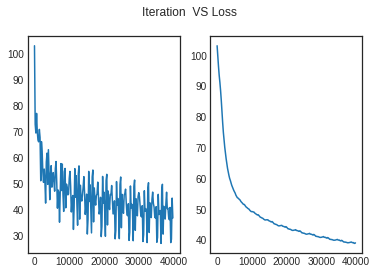

Train Epoch: 9 [3800/3999 (95%)]	Loss: 39.128697
txt:  rrect and sig,rs:
I'll dunm, hand headn; there with I parry and I
love prone than Sir John waged bosso did font to not his writt
This blind my fudscain fortunced, or thou has,
That nect strain, and th
txt:  e in say
But enfecion upon enfence Geving
have your came your worst
The servif earled we with her bay: he dover. Whose wear eat must beling rastle your king
To long be,
Now to gimt is known in brought contriceests consent our fairty, I'll she would and blind,
my flower, dirur tead follow Of umone:
Thoir sope'd know Tales bed.
A faig, I have will I
sis, helows I knows friend; in the eaust's seat shall have his quonty of heard; from be not bonsping Lord Names in merces. These we strue mouson thy a
Epoch:  9  Training Time:  1460.7346725463867  secs


In [ ]:
epochs = 10
#Start Training:
time0 = time.time()
start_time = time.time()
Total_Training_Time = 0
for epoch in range(epochs):
    smooth_loss = lstm.train_text_generation(data, smooth_loss, epoch, char_to_idx, idx_to_char)
    Total_Training_Time += (time.time() - start_time)
    lstm.test_text_generation(19, 500, idx_to_char)
    print("Epoch: ",epoch," Training Time: ", Total_Training_Time, " secs")
    start_time = time.time()